In [1]:
import numpy as np
%matplotlib notebook
import stl
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [56]:
def plot_stl(stl_file,debug=1):
    figure = plt.figure()
    axes = mplot3d.Axes3D(figure)
    
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(stl_file.vectors,edgecolors='b',linewidth=0.05))
    scale = stl_file.points.flatten('C')
    axes.auto_scale_xyz(scale,scale,scale)
    
    
    if debug == 1:
        x, y, z = np.zeros((3,3))
        ux, vx, wx = np.array([[1,0,0],[0,0,0],[0,0,0]])
        uy, vy, wy = np.array([[0,0,0],[0,1,0],[0,0,0]])
        uz, vz, wz = np.array([[0,0,0],[0,0,0],[0,0,1]])

#         utest,vtest,wtest = np.array([[1,0,0],[0,0,0],[0,0,0]])*100
        # print x y z for debugging
        axes.quiver(x,y,z,ux,vx,wx,arrow_length_ratio=0.1,color='r')
        axes.quiver(x,y,z,uy,vy,wy,arrow_length_ratio=0.1,color='g')
        axes.quiver(x,y,z,uz,vz,wz,arrow_length_ratio=0.1,color='b')
    
#         axes.quiver(x,y,z,utest,vtest,wtest,arrow_length_ratio=0.1,color='black')
        axes.quiver(0,0,0,1,1,1,arrow_length_ratio=0.1,color='black')

# functions for combine two different stl
# find the max dimensions, so we can know the bounding box, getting the height,
# width, length (because these are the step size)...
def find_mins_maxs(obj):
    minx = maxx = miny = maxy = minz = maxz = None
    for p in obj.points:
        # p contains (x, y, z)
        if minx is None:
            minx = p[stl.Dimension.X]
            maxx = p[stl.Dimension.X]
            miny = p[stl.Dimension.Y]
            maxy = p[stl.Dimension.Y]
            minz = p[stl.Dimension.Z]
            maxz = p[stl.Dimension.Z]
        else:
            maxx = max(p[stl.Dimension.X], maxx)
            minx = min(p[stl.Dimension.X], minx)
            maxy = max(p[stl.Dimension.Y], maxy)
            miny = min(p[stl.Dimension.Y], miny)
            maxz = max(p[stl.Dimension.Z], maxz)
            minz = min(p[stl.Dimension.Z], minz)
    return minx, maxx, miny, maxy, minz, maxz

def find_center(obj):
    minx,maxx,miny,maxy,minz,maxz = find_mins_maxs(obj)
    center_x = np.average([maxx,minx])
    center_y = np.average([maxy,miny])
    center_z = np.average([maxz,minz])
    print(center_x,center_y,center_z)
    
def find_obj_size(obj):
    minx,maxx,miny,maxy,minz,maxz = find_mins_maxs(obj)
    x = abs(maxx - minx)
    y = abs(maxy - miny)
    z = abs(maxz - minz)
    print(x,y,z)
    return x,y,z

def translate(_solid, step, padding, multiplier, axis):
    if 'x' == axis:
        items = 0, 3, 6
    elif 'y' == axis:
        items = 1, 4, 7
    elif 'z' == axis:
        items = 2, 5, 8
    else:
        raise RuntimeError('Unknown axis %r, expected x, y or z' % axis)

    # _solid.points.shape == [:, ((x, y, z), (x, y, z), (x, y, z))]
    _solid.points[:, items] += (step * multiplier) + (padding * multiplier)

### copy objects and also translating it
def copy_objs(obj, dims, num_rows, num_cols, num_layers):
    # obj = copy object
    # dims = tuple of x y and z of the translating distance
    # num_rows = number of in x direction
    # num_cols = number of copy in y direction
    # 
    w, l, h = dims
    copies = []
    for layer in range(num_layers):
        for row in range(num_rows):
            for col in range(num_cols):
                # skip the position where original being copied is
                if row == 0 and col == 0 and layer == 0:
                    continue
                _copy = stl.mesh.Mesh(obj.data.copy())
                # pad the space between objects by 10% of the dimension being
                # translated
                if col != 0:
                    translate(_copy, w, w / 10., col, 'x')
                if row != 0:
                    translate(_copy, l, l / 10., row, 'y')
                if layer != 0:
                    translate(_copy, h, h / 10., layer, 'z')
                copies.append(_copy)
    return copies

### Copy the objects 
def copy_obj(obj):
    # x,y,z
#     w,l,h = dims
    _copy = stl.mesh.Mesh(obj.data.copy())
    return(_copy)

# Scale object using rotation matrix
def scale_obj(obj,scale):
    scale_mat = np.identity(3)*scale
    stl.mesh.Mesh.rotate_using_matrix(obj,scale_mat)

    
def translate_obj(obj,x,y,z,scale=1):
    translate(obj,x*scale,0,1,'x')
    translate(obj,y*scale,0,1,'y')
    translate(obj,z*scale,0,1,'z')

def rotate_obj(obj,x,y,z):
    obj.rotate([0.5,0,0],np.radians(x))
    obj.rotate([0,0.5,0],np.radians(y))
    obj.rotate([0,0,0.5],np.radians(z))

def copy_scale_translate_sphere(obj,x,y,z,scale_num,scale_factor = 80.0/3):
    _obj = copy_obj(obj)
    scale_obj(_obj,scale=scale_num*scale_factor)
    translate(_obj,x*scale_factor,0,1,'x')
    translate(_obj,y*scale_factor,0,1,'y')
    translate(_obj,z*scale_factor,0,1,'z')
    return _obj

def copy_scale_translate_cyl(x,
                             y,
                             z,
                             axis,
                             scale_factor = 80.0/3,
                             cylinder_x=cylinder_x,
                             cylinder_y=cylinder_y,
                             cylinder_z=cylinder_z):
    cylinder_x = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_x.stl')
    cylinder_y = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_y.stl')
    cylinder_z = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_z.stl')
    if axis == 0:
        _obj = copy_obj(cylinder_x)
    elif axis == 1:
        _obj = copy_obj(cylinder_y)
    elif axis == 2:
        _obj = copy_obj(cylinder_z)
    
    scale_obj(_obj,scale = 0.1*scale_factor)
    translate(_obj,x*scale_factor,0,1,'x')
    translate(_obj,y*scale_factor,0,1,'y')
    translate(_obj,z*scale_factor,0,1,'z')
    
    return _obj


def read_n_construct_STL(input_file,output_file='output.stl',plot=False):
    # load sphere file
    sphere = stl.mesh.Mesh.from_file('stl_data/stl_test/unit_circle_1.5_op1.stl')
    
    # load cylinder file
    cylinder_x = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_x.stl')
    cylinder_y = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_y.stl')
    cylinder_z = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_z.stl')
    
    # read the datafile
    coord = np.genfromtxt(input_file,delimiter=',')
    
    
    scale_factor = 80.0/3

    sphere_list = []
    cylinder_list = []
    for i in range(len(coord)):
        # check if it sphere or cylinder
        if coord[i,0] == 0:
            obj = copy_scale_translate_sphere(sphere,coord[i,1],coord[i,2],coord[i,3],coord[i,4])
            sphere_list.append(obj)
        elif coord[i,0] == 1:
            obj = copy_scale_translate_cyl(coord[i,1],coord[i,2],coord[i,3],coord[i,4],80.0/3,cylinder_x,cylinder_y,cylinder_z)
            cylinder_list.append(obj)

    
    combined = stl.mesh.Mesh(np.concatenate([i.data for i in sphere_list]+[i.data for i in cylinder_list]))
    if plot == True:
        plot_stl(combined,1)
    combined.save('stl_data/stl_test/'+str(output_file),mode=stl.Mode.ASCII)

2.9957871 2.993431 3.0


<IPython.core.display.Javascript object>


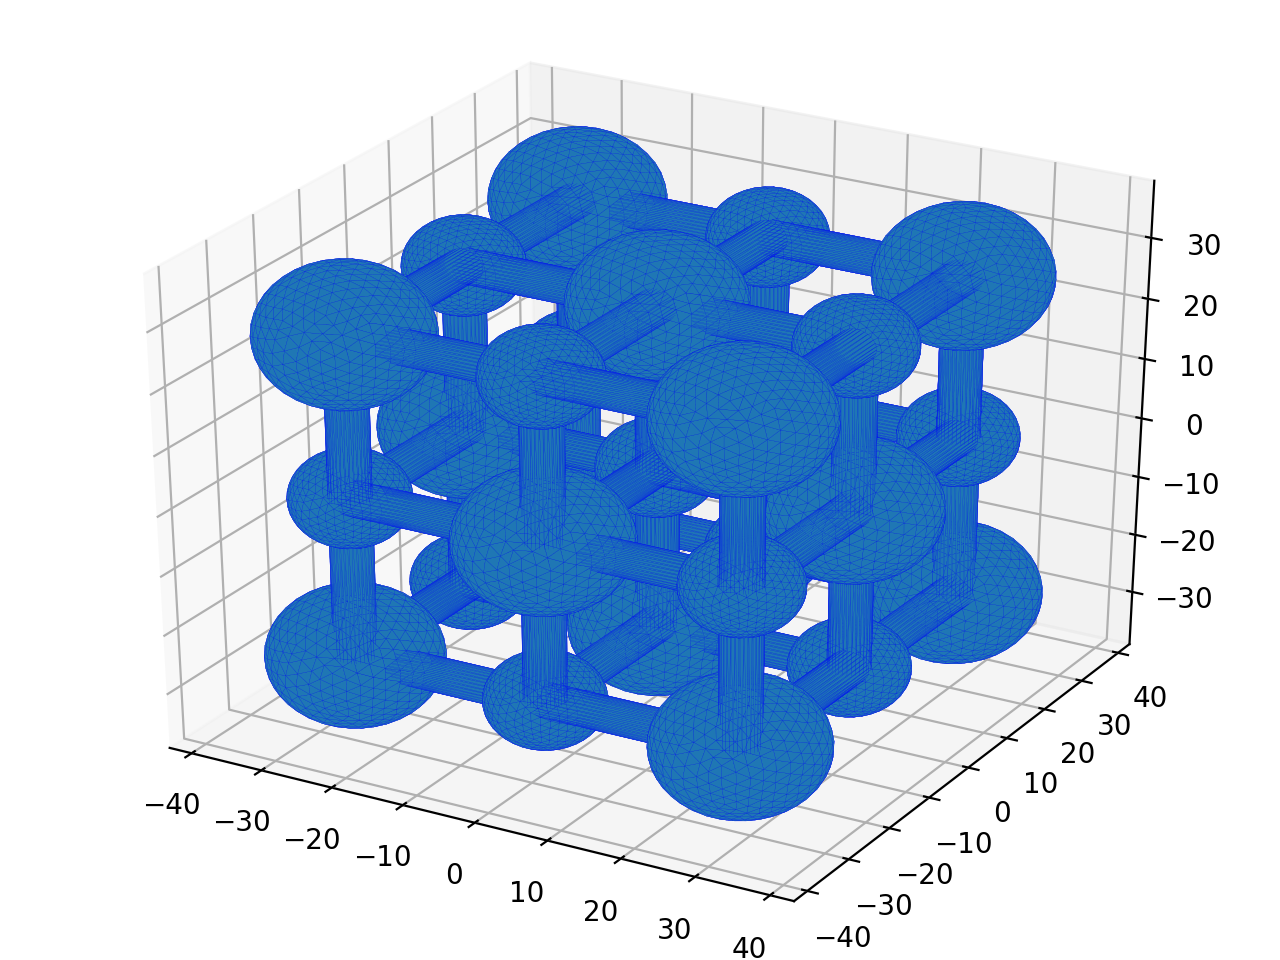

In [48]:
# Mesh


################################## Sphere ####################
coord = np.genfromtxt('nacl_v1_sphere.csv',delimiter=',',skip_header=1)
# print(coord)
sphere = stl.mesh.Mesh.from_file('stl_data/stl_test/unit_circle_1.5_op1.stl')
x_len,y_len,z_len =find_obj_size(sphere)

# print(x_len,y_len,z_len)
# append the list
sphere_list = []
scale_factor = 80/3 # max is 8cm
for i in range(len(coord)):
    # 
#     obj_coord = (coord[i,0]*z_len,coord[i,1]*z_len,coord[i,2]*z_len)
    #   print(obj_coord)
#     obj = copy_scale_obj(sphere,obj_coord,coord[i,3])

    # scale then translate
#         scale_obj(sphere_2,0.5)
#         translate(sphere_2,400,0,1,'x')
    obj = copy_scale_translate_sphere(sphere,coord[i,1],coord[i,2],coord[i,3],coord[i,4])
    sphere_list.append(obj)

# combine 

############################## Cylinder #######################
cylinder = np.genfromtxt('nacl_v1_cylinder.csv',delimiter=',',skip_header=1)

cylinder_x = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_x.stl')
cylinder_y = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_y.stl')
cylinder_z = stl.mesh.Mesh.from_file('stl_data/stl_test/cylinder_rad1_len10_edgecenter_z.stl')

cylinder_list = []
for i in range(len(cylinder)):
    obj = copy_scale_translate_cyl(cylinder[i,1],cylinder[i,2],cylinder[i,3],cylinder[i,4],80.0/3,cylinder_x,cylinder_y,cylinder_z)
    cylinder_list.append(obj)

# combined = stl.mesh.Mesh(np.concatenate([i.data for i in sphere_list]))
combined = stl.mesh.Mesh(np.concatenate([i.data for i in sphere_list]+[i.data for i in cylinder_list]))




plot_stl(combined,1)
combined.save('stl_data/stl_test/multi_varying_size.stl',mode=stl.Mode.ASCII)

<IPython.core.display.Javascript object>


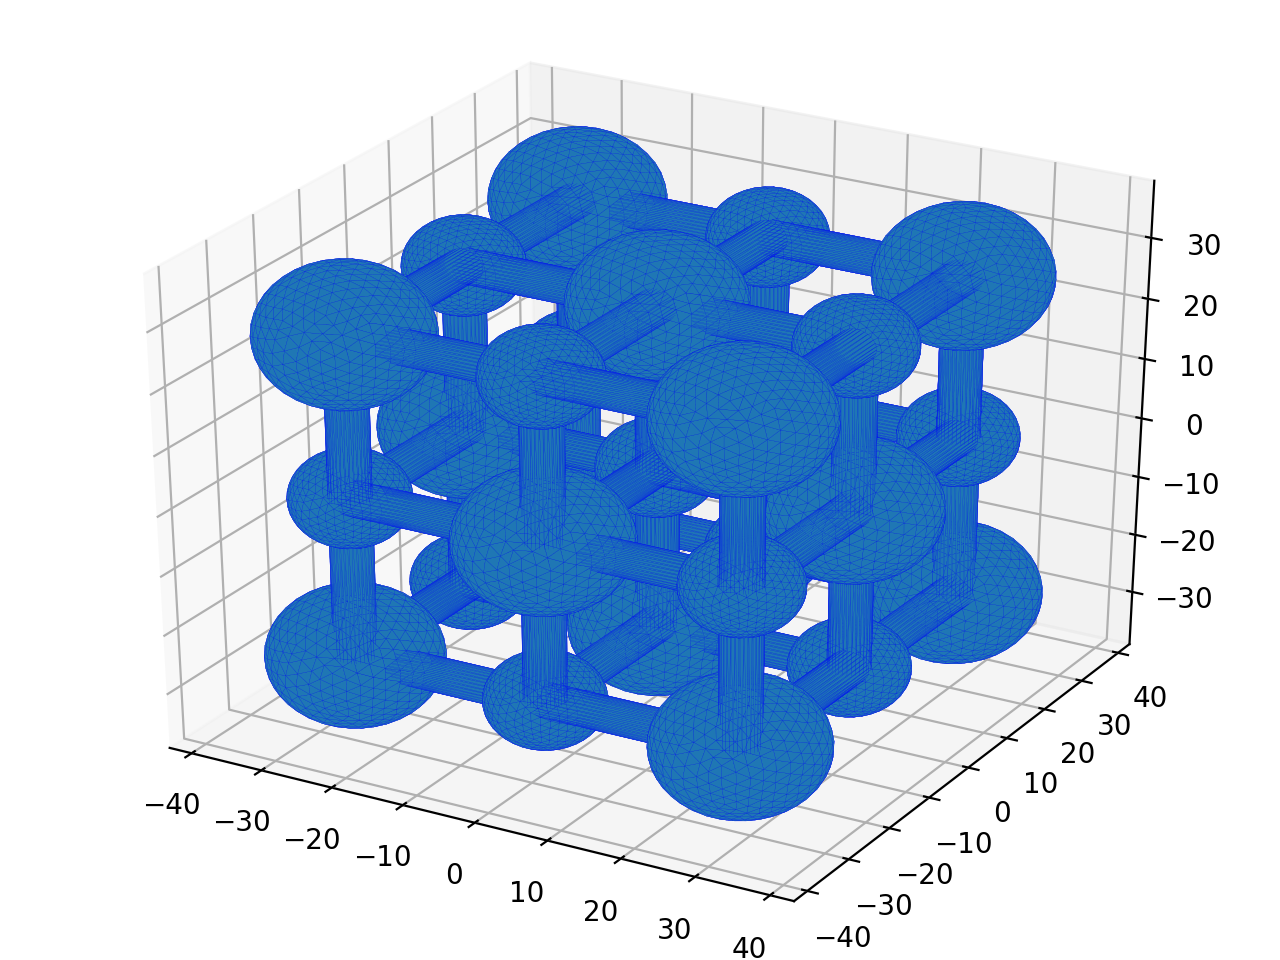

In [57]:
read_n_construct_STL('nacl_v1.csv','test_output_file.stl',1)